## Group 11 Final Project: Fine tuning VGG16, VGG19 and ResNetRS101 for Human Activity Classification

## Install required libraries and load it

In [1]:
#!pip install -r requirements.txt

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

## Load the datasets

In [2]:
train_data = pd.read_csv("../data/Training_set.csv")
test_data = pd.read_csv("../data/Testing_set.csv")

In [3]:
train_path = "../data/train/"
test_path = "../data/test/"

In [4]:
train_img = glob.glob(train_path+"/*")
test_img = glob.glob(test_path+"/*")

In [5]:
len(train_img)

12601

In [6]:
train_data.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


### Check images from training dataset

In [7]:
def display_image():
    num = random.randint(1,10000)
    imgg = "Image_{}.jpg".format(num)
    train = train_path
    if os.path.exists(train+imgg):
        testImage = img.imread(train+imgg)
        plt.imshow(testImage)
        plt.title("{}".format(train_data.loc[train_data['filename'] == "{}".format(imgg), 'label'].item()))

    else:
        #print(train+img)
        print("File Path not found!!")

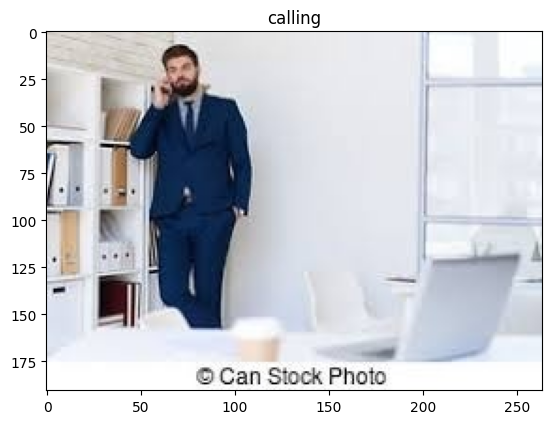

In [8]:
display_image()

## Define some helper functions

In [9]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(15, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

## Function to read images as array

In [10]:
# Function to read images as array

def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((120,120)))

# Function to predict

def test_predict(test_image, model):
    result = model.predict(np.asarray([read_image(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print(prediction)
    prediction=class_names[prediction]
    print("probability: "+str(np.round(np.max(result)*100)) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

## Data Preprocessing

In [11]:
class_names = ['calling','clapping','cycling','dancing','drinking','eating','fighting',
               'hugging','laughing','listening_to_music','running','sitting','sleeping','texting','using_laptop']
num_classes = len(class_names)

In [12]:
from sklearn.model_selection import train_test_split
def data_preprocess(data, path, image_data):
    filename = data['filename']
    situation = data['label']
    img_data = []
    img_label = []
    length = len(image_data)
    for i in (range(len(image_data)-1)):
        t = path + filename[i]
        temp_img = Image.open(t)
        img_data.append(np.asarray(temp_img.resize((120,120))))
        img_label.append(situation[i])
    x_train, x_val, y_train, y_val = train_test_split(img_data, img_label, test_size=0.2,
                                                      stratify=img_label, random_state=101)
    print("Value counts for different classes in validation dataset:")
    print(pd.Series(y_val).value_counts())
    x_train = np.asarray(x_train)
    x_val = np.asarray(x_val)
    y_train = to_categorical([class_names.index(label) for label in y_train], num_classes=num_classes)
    y_val = to_categorical([class_names.index(label) for label in y_val], num_classes=num_classes)
    return x_train,x_val,y_train,y_val

In [13]:
x_train,x_val, y_train,y_val = data_preprocess(train_data, train_path, train_img)

Value counts for different classes in validation dataset:
clapping              168
dancing               168
listening_to_music    168
sleeping              168
texting               168
cycling               168
eating                168
laughing              168
drinking              168
calling               168
using_laptop          168
fighting              168
running               168
sitting               168
hugging               168
Name: count, dtype: int64


In [14]:
input_shape = (120,120,3)

## Model 1 - VGG16 

In [14]:
vgg_model = tf.keras.applications.VGG16(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in vgg_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 14,849,871
Trainable params: 135,183
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
history = model.fit(x_train,y_train, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
315/315 [==============================] - 27s 72ms/step - loss: 4.2865 - accuracy: 0.2101 - val_loss: 2.1700 - val_accuracy: 0.3175
Epoch 2/20
315/315 [==============================] - 21s 66ms/step - loss: 2.1589 - accuracy: 0.3094 - val_loss: 1.9488 - val_accuracy: 0.3730
Epoch 3/20
315/315 [==============================] - 21s 66ms/step - loss: 1.9366 - accuracy: 0.3759 - val_loss: 1.8428 - val_accuracy: 0.4198
Epoch 4/20
315/315 [==============================] - 21s 66ms/step - loss: 1.7917 - accuracy: 0.4094 - val_loss: 1.7997 - val_accuracy: 0.4389
Epoch 5/20
315/315 [==============================] - 21s 66ms/step - loss: 1.6716 - accuracy: 0.4525 - val_loss: 1.7502 - val_accuracy: 0.4329
Epoch 6/20
315/315 [==============================] - 21s 66ms/step - loss: 1.5813 - accuracy: 0.4745 - val_loss: 1.7436 - val_accuracy: 0.4460
Epoch 7/20
315/315 [==============================] - 21s 66ms/step - loss: 1.5060 - accuracy: 0.5021 - val_loss: 1.7376 - val_accuracy:

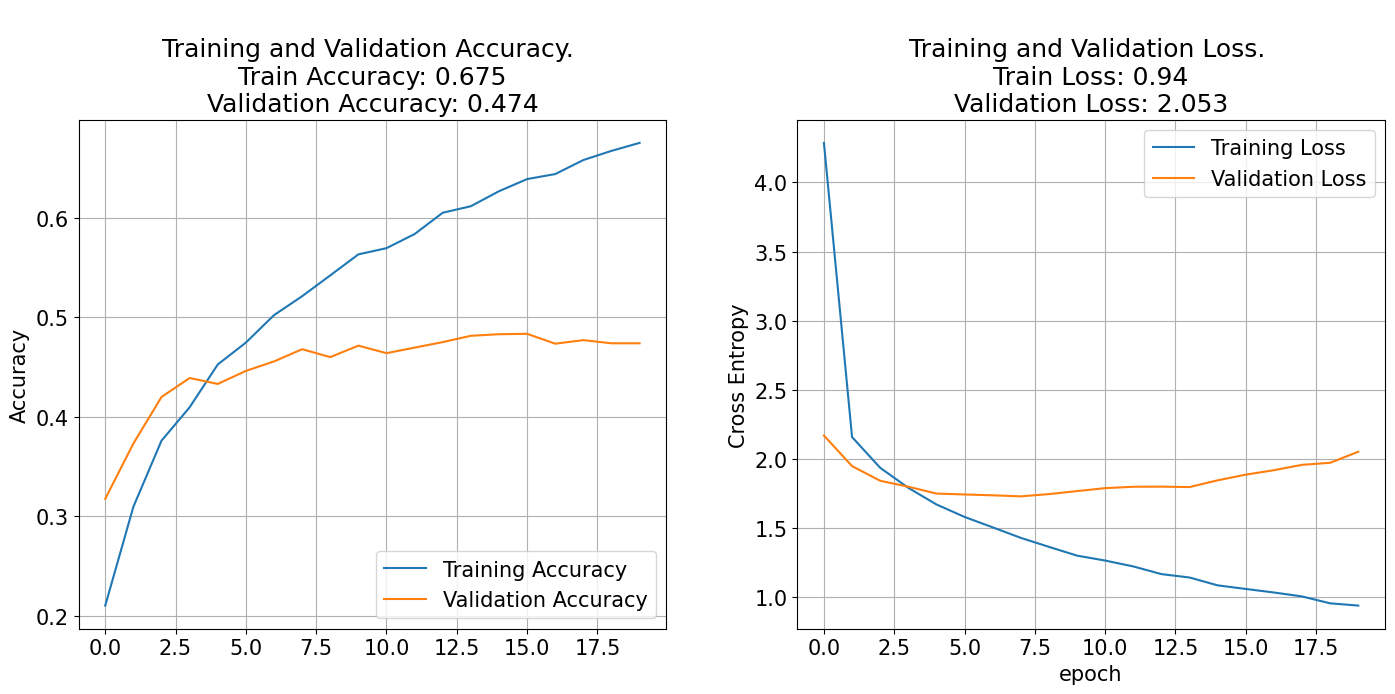

In [17]:
plot_history(history)

In [18]:
model.save("saved_models/model_1.h5")
model.save_weights("saved_models/model_weights_1.h5")

### Data augmentation

In [17]:
# Define the data augmentation generator
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Apply data augmentation to train data
augmented_x_train = np.array([data_augmentation.random_transform(image) for image in x_train])

## Model 2 - VGG16 with L2 regularization and data augmentation

In [15]:
vgg_model = tf.keras.applications.VGG16(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in vgg_model.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(vgg_model)
model2.add(Flatten())
model2.add(Dense(512, activation="relu", kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(15, activation="softmax", kernel_regularizer=l2(0.01)))
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
history2 = model2.fit(augmented_x_train,y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
315/315 [==============================] - 27s 72ms/step - loss: 8.5535 - accuracy: 0.2085 - val_loss: 5.6205 - val_accuracy: 0.3516
Epoch 2/20
315/315 [==============================] - 21s 66ms/step - loss: 4.9777 - accuracy: 0.3187 - val_loss: 4.0978 - val_accuracy: 0.3960
Epoch 3/20
315/315 [==============================] - 21s 66ms/step - loss: 3.7581 - accuracy: 0.3783 - val_loss: 3.2761 - val_accuracy: 0.4302
Epoch 4/20
315/315 [==============================] - 21s 66ms/step - loss: 3.1274 - accuracy: 0.3990 - val_loss: 2.8845 - val_accuracy: 0.4476
Epoch 5/20
315/315 [==============================] - 21s 66ms/step - loss: 2.7838 - accuracy: 0.4223 - val_loss: 2.6675 - val_accuracy: 0.4365
Epoch 6/20
315/315 [==============================] - 21s 66ms/step - loss: 2.6003 - accuracy: 0.4280 - val_loss: 2.4989 - val_accuracy: 0.4548
Epoch 7/20
315/315 [==============================] - 21s 66ms/step - loss: 2.4729 - accuracy: 0.4347 - val_loss: 2.4196 - val_accuracy:

In [17]:
model2.save("saved_models/model_2.h5")
model2.save_weights("saved_models/model_weights_2.h5")

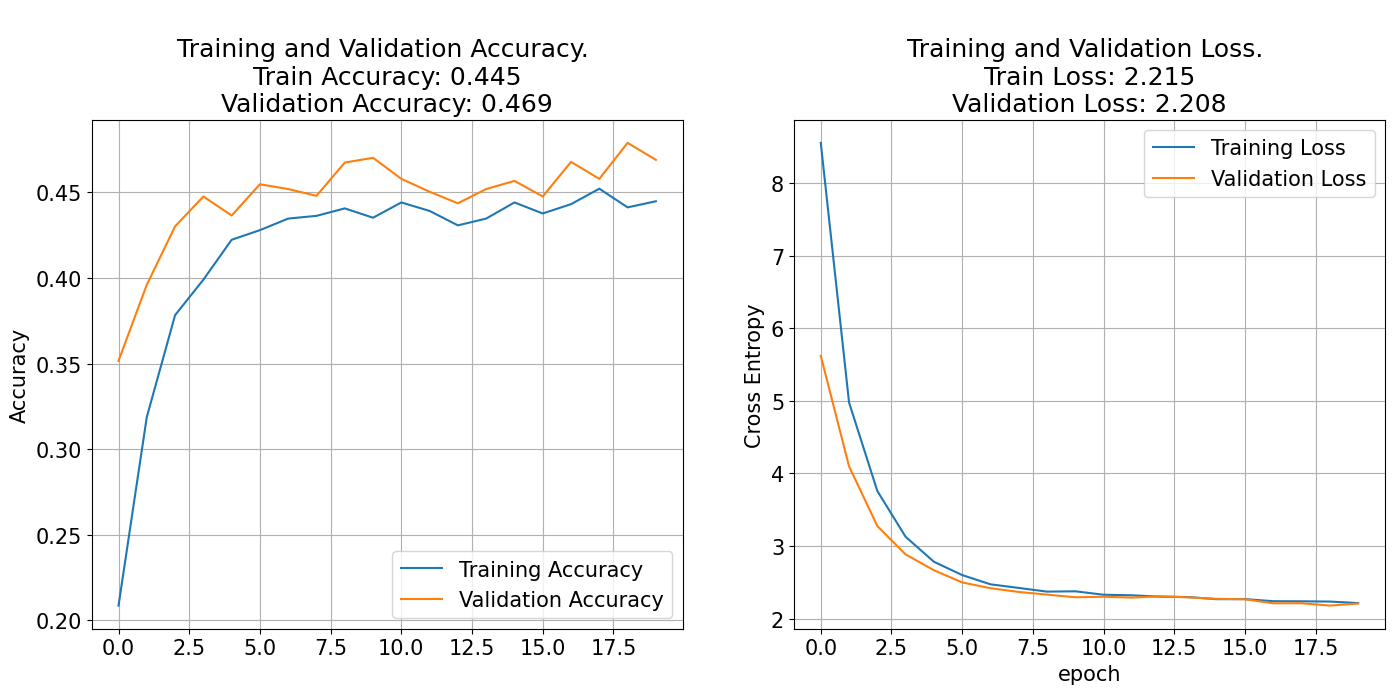

In [18]:
plot_history(history2)

## Inference on model 1

1/1 [==============================] - 1s 807ms/step
9
probability: 25.0%
Predicted class :  listening_to_music


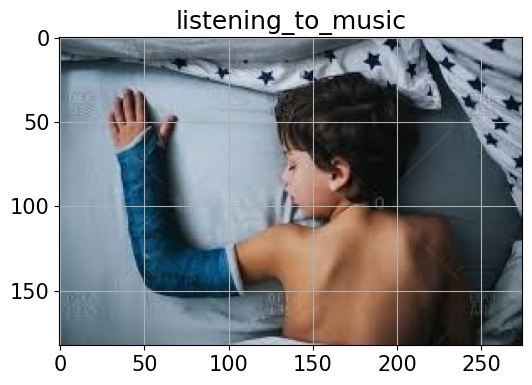

In [24]:
model1 = tf.keras.models.load_model("saved_models/model_1.h5")
test_predict("./data/test/Image_1.jpg", model1)

## Inference on Model 2

1/1 [==============================] - 0s 143ms/step
12
probability: 35.0%
Predicted class :  sleeping


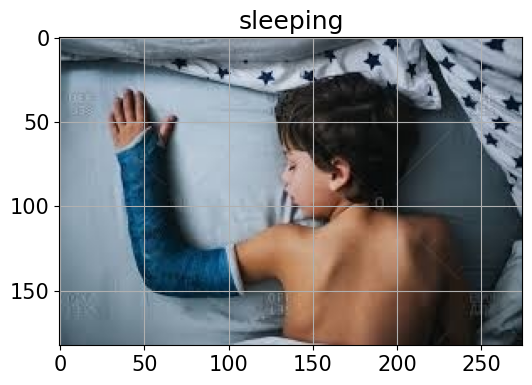

In [25]:
test_predict("./data/test/Image_1.jpg", model2)

## Model 3 - VGG19 

In [26]:

vgg19_model = tf.keras.applications.VGG19(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in vgg19_model.layers:
    layer.trainable = False

model3 = Sequential()
model3.add(vgg19_model)
model3.add(Flatten())
model3.add(Dense(256, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(15, activation="softmax"))
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                3855      
                                                                 
Total params: 20,159,567
Trainable params: 135,183
Non-trainable params: 20,024,384
_________________________________________________________________


In [27]:
history3 = model3.fit(x_train,y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
315/315 [==============================] - 54s 169ms/step - loss: 3.9194 - accuracy: 0.2182 - val_loss: 2.0995 - val_accuracy: 0.3341
Epoch 2/20
315/315 [==============================] - 57s 181ms/step - loss: 2.1140 - accuracy: 0.3225 - val_loss: 1.8771 - val_accuracy: 0.4063
Epoch 3/20
315/315 [==============================] - 58s 184ms/step - loss: 1.8813 - accuracy: 0.3928 - val_loss: 1.8228 - val_accuracy: 0.4214
Epoch 4/20
315/315 [==============================] - 56s 179ms/step - loss: 1.7404 - accuracy: 0.4327 - val_loss: 1.7767 - val_accuracy: 0.4452
Epoch 5/20
315/315 [==============================] - 56s 179ms/step - loss: 1.6291 - accuracy: 0.4688 - val_loss: 1.7522 - val_accuracy: 0.4484
Epoch 6/20
315/315 [==============================] - 56s 179ms/step - loss: 1.5416 - accuracy: 0.4939 - val_loss: 1.7160 - val_accuracy: 0.4643
Epoch 7/20
315/315 [==============================] - 56s 179ms/step - loss: 1.4436 - accuracy: 0.5258 - val_loss: 1.7131 - val_ac

In [28]:
model3.save("saved_models/model_3.h5")
model3.save_weights("saved_models/model_weights_3.h5")

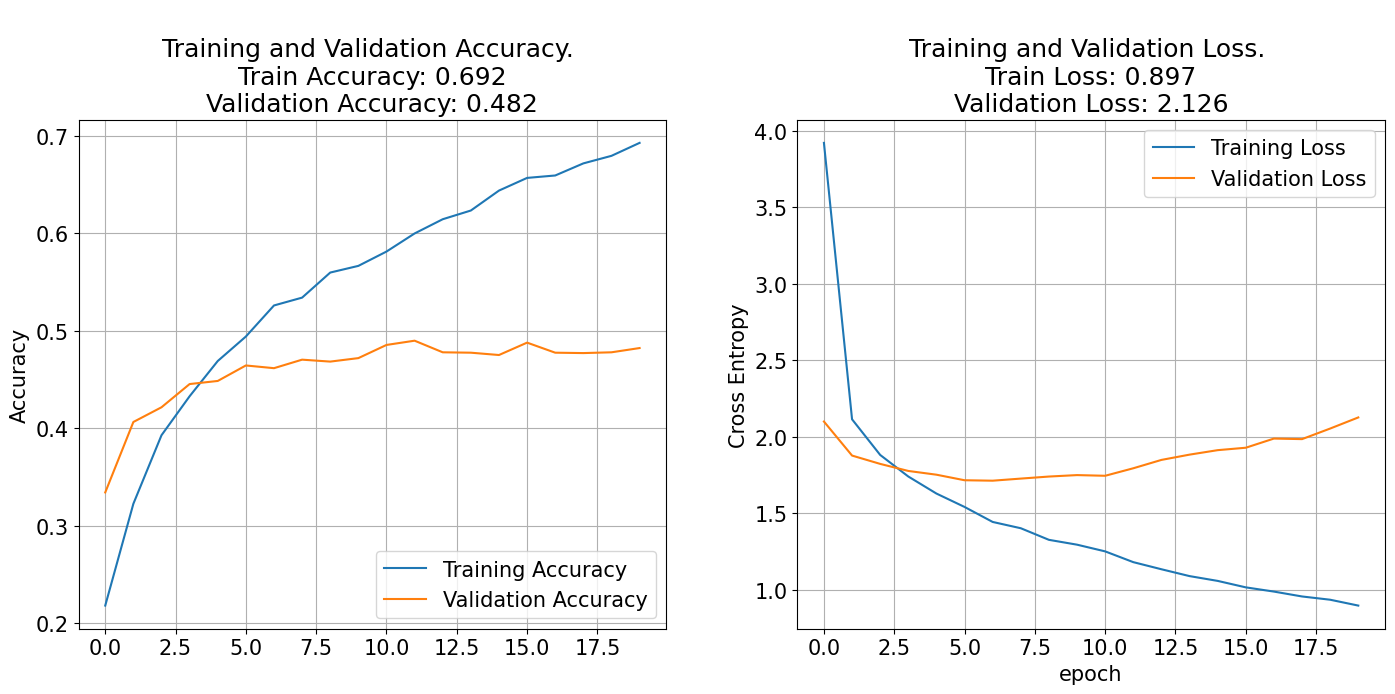

In [29]:
plot_history(history3)

## Model 4 - VGG19 with regularization and data augmentation

In [15]:

vgg19_model = tf.keras.applications.VGG19(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in vgg19_model.layers:
    layer.trainable = False

model4 = Sequential()
model4.add(vgg19_model)
model4.add(Flatten())
model4.add(Dense(256, activation="relu", kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.5))
model4.add(Dense(15, activation="softmax", kernel_regularizer=l2(0.01)))
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 20,159,567
Trainable params: 135,183
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:
history4 = model4.fit(augmented_x_train,y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
315/315 [==============================] - 73s 208ms/step - loss: 6.8912 - accuracy: 0.1700 - val_loss: 4.6552 - val_accuracy: 0.3087
Epoch 2/20
315/315 [==============================] - 63s 200ms/step - loss: 4.2797 - accuracy: 0.2731 - val_loss: 3.5919 - val_accuracy: 0.3659
Epoch 3/20
315/315 [==============================] - 63s 201ms/step - loss: 3.3546 - accuracy: 0.3399 - val_loss: 2.9524 - val_accuracy: 0.3988
Epoch 4/20
315/315 [==============================] - 64s 202ms/step - loss: 2.8561 - accuracy: 0.3694 - val_loss: 2.5635 - val_accuracy: 0.4306
Epoch 5/20
315/315 [==============================] - 64s 204ms/step - loss: 2.5622 - accuracy: 0.3888 - val_loss: 2.3779 - val_accuracy: 0.4393
Epoch 6/20
315/315 [==============================] - 64s 203ms/step - loss: 2.4134 - accuracy: 0.4032 - val_loss: 2.2626 - val_accuracy: 0.4421
Epoch 7/20
315/315 [==============================] - 64s 203ms/step - loss: 2.3051 - accuracy: 0.4191 - val_loss: 2.2507 - val_ac

In [19]:
model4.save("saved_models/model_4.h5")
model4.save_weights("saved_models/model_weights_4.h5")

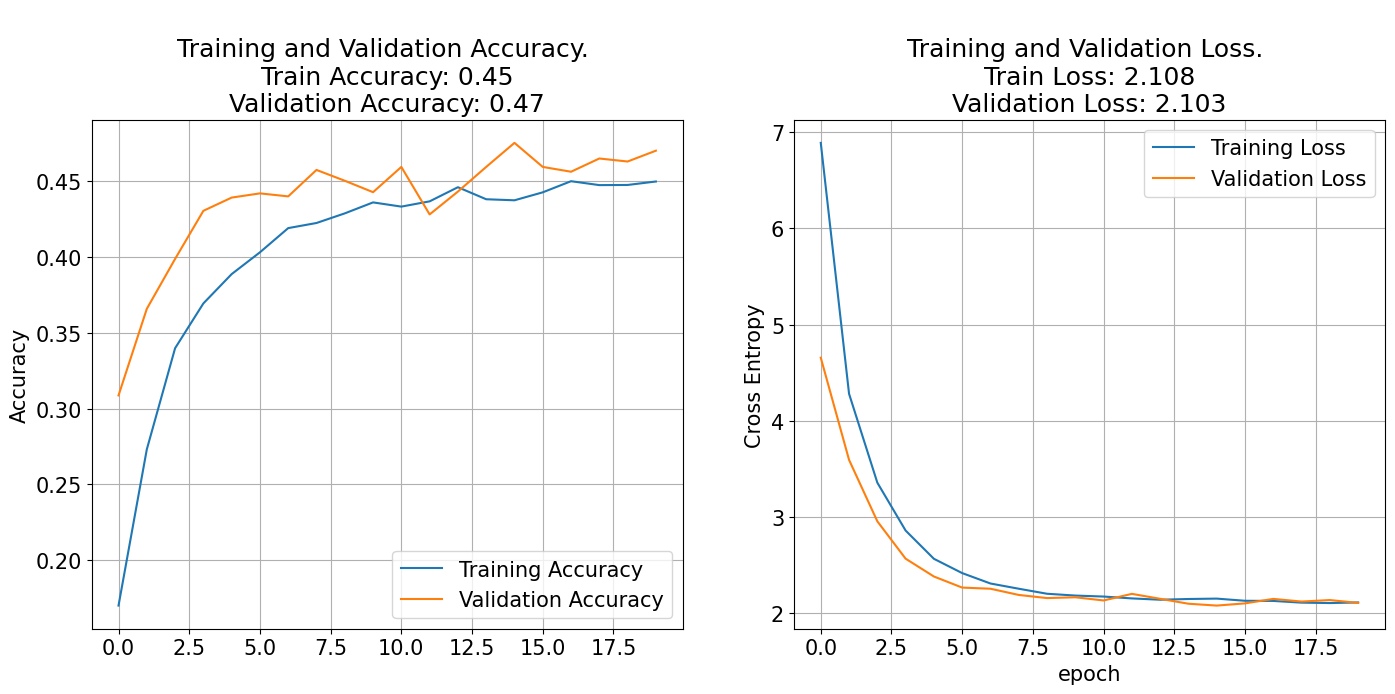

In [20]:
plot_history(history4)

## Model 5 - ResNetRS101 with data augmentation and regularization

In [21]:

resnet_model = tf.keras.applications.ResNetRS101(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in resnet_model.layers:
    layer.trainable = False

model5 = Sequential()
model5.add(resnet_model)
model5.add(Flatten())
model5.add(Dense(256, activation="relu", kernel_regularizer=l2(0.01)))
model5.add(Dropout(0.5))
model5.add(Dense(15, activation="softmax", kernel_regularizer=l2(0.01)))
model5.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet-rs-101 (Functional)  (None, 2048)              61675296  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                3855      
                                                                 
Total params: 62,203,695
Trainable params: 528,399
Non-trainable params: 61,675,296
_________________________________________________________________


In [22]:
history5 = model5.fit(augmented_x_train,y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
315/315 [==============================] - 52s 146ms/step - loss: 3.5817 - accuracy: 0.4396 - val_loss: 2.0357 - val_accuracy: 0.6175
Epoch 2/20
315/315 [==============================] - 44s 140ms/step - loss: 2.0738 - accuracy: 0.5359 - val_loss: 1.7760 - val_accuracy: 0.5960
Epoch 3/20
315/315 [==============================] - 44s 140ms/step - loss: 1.8877 - accuracy: 0.5510 - val_loss: 1.6965 - val_accuracy: 0.6036
Epoch 4/20
315/315 [==============================] - 44s 140ms/step - loss: 1.8551 - accuracy: 0.5514 - val_loss: 1.6473 - val_accuracy: 0.6266
Epoch 5/20
315/315 [==============================] - 44s 139ms/step - loss: 1.8306 - accuracy: 0.5517 - val_loss: 1.6739 - val_accuracy: 0.6115
Epoch 6/20
315/315 [==============================] - 44s 139ms/step - loss: 1.8198 - accuracy: 0.5505 - val_loss: 1.6322 - val_accuracy: 0.6222
Epoch 7/20
315/315 [==============================] - 44s 139ms/step - loss: 1.8233 - accuracy: 0.5489 - val_loss: 1.5955 - val_ac

In [23]:
model5.save("saved_models/model_5.h5")
model5.save_weights("saved_models/model_weights_5.h5")

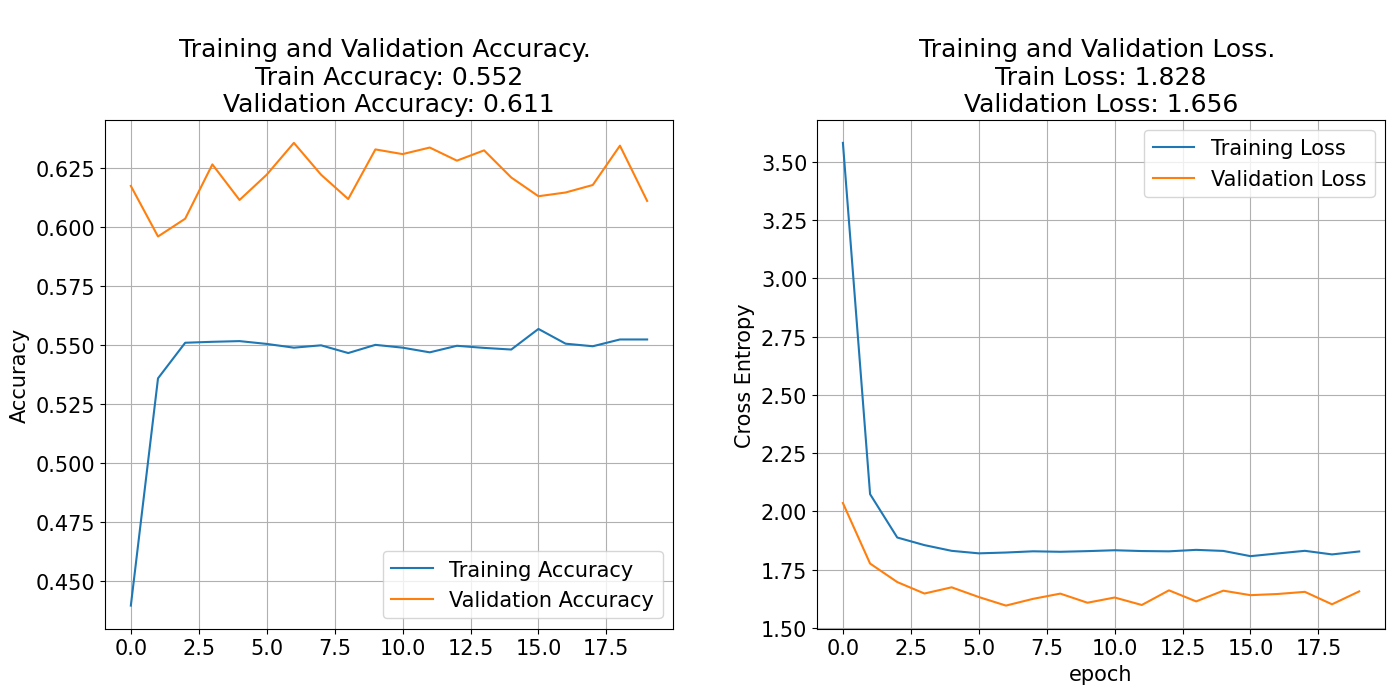

In [24]:
plot_history(history5)

## Model 6 - ResNetRS101 with data augmentation and regularization with l2=0.001

In [25]:

resnet_model = tf.keras.applications.ResNetRS101(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in resnet_model.layers:
    layer.trainable = False

model6 = Sequential()
model6.add(resnet_model)
model6.add(Flatten())
model6.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
model6.add(Dropout(0.3))
model6.add(Dense(15, activation="softmax", kernel_regularizer=l2(0.001)))
model6.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet-rs-101 (Functional)  (None, 2048)              61675296  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                                 
Total params: 62,203,695
Trainable params: 528,399
Non-trainable params: 61,675,296
_________________________________________________________________


In [27]:
history6 = model6.fit(augmented_x_train,y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
315/315 [==============================] - 35s 97ms/step - loss: 1.9923 - accuracy: 0.4869 - val_loss: 1.4909 - val_accuracy: 0.6270
Epoch 2/20
315/315 [==============================] - 29s 92ms/step - loss: 1.5175 - accuracy: 0.6094 - val_loss: 1.4151 - val_accuracy: 0.6425
Epoch 3/20
315/315 [==============================] - 29s 92ms/step - loss: 1.3514 - accuracy: 0.6541 - val_loss: 1.4074 - val_accuracy: 0.6417
Epoch 4/20
315/315 [==============================] - 29s 92ms/step - loss: 1.2581 - accuracy: 0.6801 - val_loss: 1.3539 - val_accuracy: 0.6587
Epoch 5/20
315/315 [==============================] - 29s 93ms/step - loss: 1.2028 - accuracy: 0.6970 - val_loss: 1.4051 - val_accuracy: 0.6448
Epoch 6/20
315/315 [==============================] - 29s 93ms/step - loss: 1.1480 - accuracy: 0.7175 - val_loss: 1.4083 - val_accuracy: 0.6512
Epoch 7/20
315/315 [==============================] - 29s 93ms/step - loss: 1.1108 - accuracy: 0.7334 - val_loss: 1.4320 - val_accuracy:

In [28]:
model6.save("saved_models/model_6.h5")
model6.save_weights("saved_models/model_weights_6.h5")

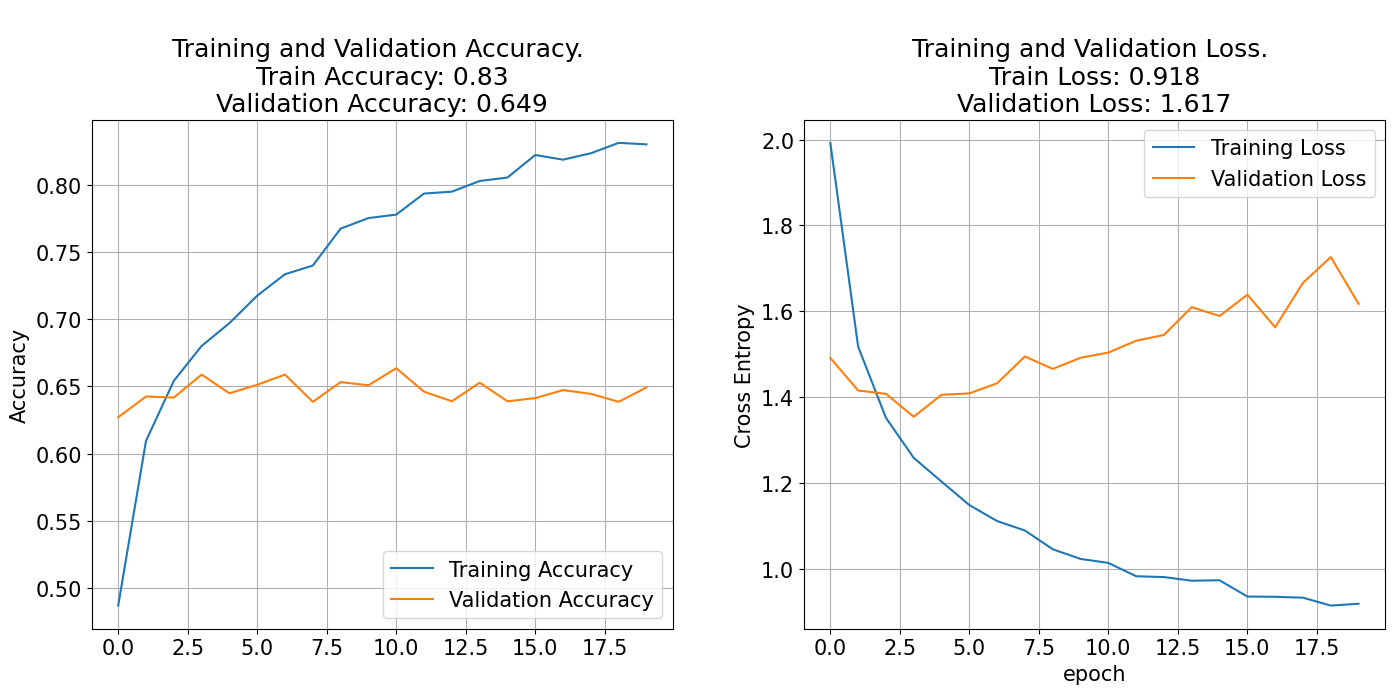

In [29]:
plot_history(history6)

## Model 7 - ResNetRS101 with data augmentation and regularization with l2=0.005

In [30]:

resnet_model = tf.keras.applications.ResNetRS101(include_top=False,
                                        input_shape=input_shape,
                                        pooling="avg", classes=15,
                                        weights="imagenet")
for layer in resnet_model.layers:
    layer.trainable = False

model7 = Sequential()
model7.add(resnet_model)
model7.add(Flatten())
model7.add(Dense(256, activation="relu", kernel_regularizer=l2(0.005)))
model7.add(Dropout(0.3))
model7.add(Dense(15, activation="softmax", kernel_regularizer=l2(0.005)))
model7.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet-rs-101 (Functional)  (None, 2048)              61675296  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 15)                3855      
                                                                 
Total params: 62,203,695
Trainable params: 528,399
Non-trainable params: 61,675,296
_________________________________________________________________


In [31]:
history7 = model7.fit(augmented_x_train,y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
315/315 [==============================] - 36s 99ms/step - loss: 2.8098 - accuracy: 0.4841 - val_loss: 1.9007 - val_accuracy: 0.6151
Epoch 2/20
315/315 [==============================] - 29s 93ms/step - loss: 1.8315 - accuracy: 0.5830 - val_loss: 1.5780 - val_accuracy: 0.6389
Epoch 3/20
315/315 [==============================] - 29s 93ms/step - loss: 1.6316 - accuracy: 0.6062 - val_loss: 1.5410 - val_accuracy: 0.6373
Epoch 4/20
315/315 [==============================] - 29s 93ms/step - loss: 1.5655 - accuracy: 0.6170 - val_loss: 1.5311 - val_accuracy: 0.6393
Epoch 5/20
315/315 [==============================] - 29s 93ms/step - loss: 1.5279 - accuracy: 0.6295 - val_loss: 1.5274 - val_accuracy: 0.6401
Epoch 6/20
315/315 [==============================] - 29s 93ms/step - loss: 1.5346 - accuracy: 0.6258 - val_loss: 1.5252 - val_accuracy: 0.6433
Epoch 7/20
315/315 [==============================] - 29s 93ms/step - loss: 1.5356 - accuracy: 0.6256 - val_loss: 1.5000 - val_accuracy:

In [32]:
model7.save("saved_models/model_7.h5")
model7.save_weights("saved_models/model_weights_7.h5")

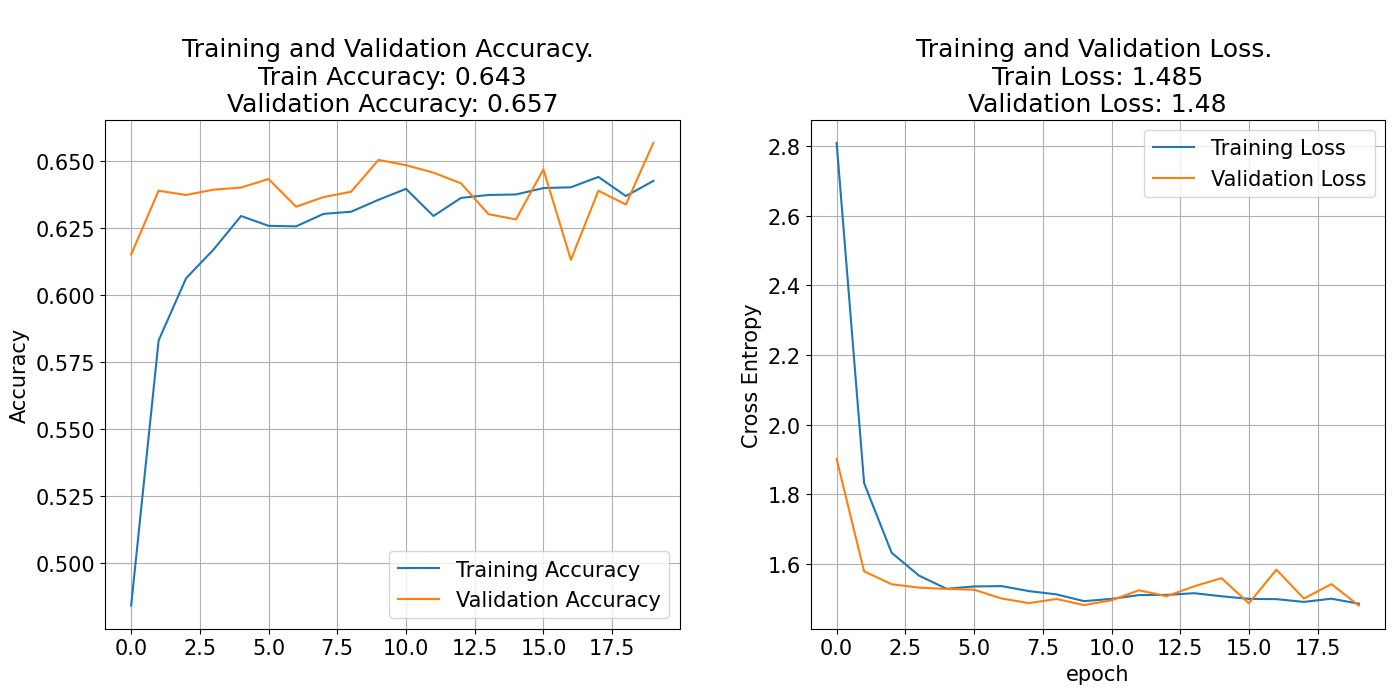

In [33]:
plot_history(history7)

## Inference on ResNet 18

1/1 [==============================] - 2s 2s/step
12
probability: 80.0%
Predicted class :  sleeping


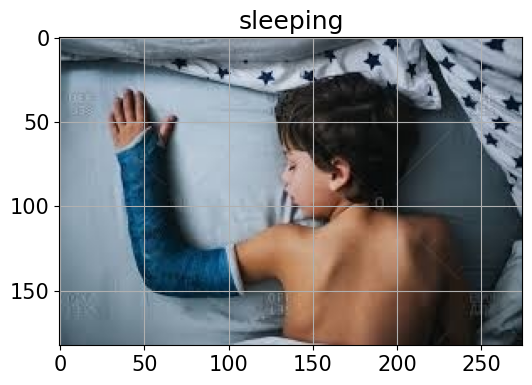

In [34]:
test_predict("./data/test/Image_1.jpg", model7)

1/1 [==============================] - 0s 20ms/step
10
probability: 52.0%
Predicted class :  running


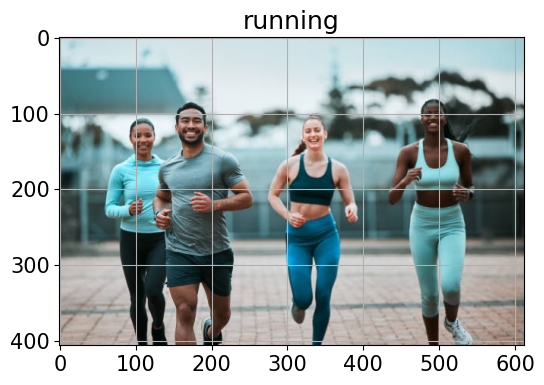

In [35]:
test_predict("./data/test/1.jpg", model7)